In [1]:
## importing all libraries and dependencies
import pandas as pd
import numpy as np
import os
from os import listdir
import glob
from os.path import isfile, join
import shutil
import PIL
from PIL import Image
import random
import math
from heapq import merge
from random import *
import scipy as sp
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import zscore

In [2]:
#match the behavioral and physio files
scl_dir = '/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/SCR(txt)/'
beh_dir = '/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/all_data/'
scl_outputs = '/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/SCL_Lila/scls/'
beh_outputs = '/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/SCL_Lila/behs/'
final_outputs = '/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/SCL_Lila/outs/'

In [3]:
import warnings
warnings.filterwarnings('ignore')

pt_dir_lst = []
scl_pts = [p for p in listdir(scl_dir)]
for i in scl_pts:
    pt_dir = scl_dir + i
    pt_dir_lst.append(pt_dir)

In [4]:
for a in pt_dir_lst:
    pt_scl = []
    pt_num = a[-7:-5]
    pt_files = [b for b in listdir(a)]
    for c in pt_files:
        run_num = c[-5]
        df = pd.read_csv((a +'/'+ c), sep="\t", header=None, skiprows = 11)
        # you can check about the last added NAN column through df[df.iloc[:, 4].notnull()==True]
        df.drop(columns=df.columns[-1],  axis=1,  inplace=True)
        df.columns = ["time", "GSR","shock","stims"]
        ## sample rate is 5msec so Stim readings are 700 while the iti is 200
        tmp = df.stims.idxmax()
        #thats not accounting for the first actual stim- this is from first instance of fixation to the last instance of fixation
        #add in a buffer if needed- we basically dont know how long of a csv we have so get them all in the same size and then cut off/drop values/ take means for context
        stop = df[df.stims != 0].index[-1]
        one_less = tmp - 1
        dummy_df = pd.DataFrame(df.iloc[df.index[one_less]]).T
        if (tmp - 700) >= 0:
            df_dup = df
        if (tmp - 700) < 0:
            r = abs(tmp-700)
            dummy_dfr = pd.concat([dummy_df]*r, ignore_index = True)
            df_dup = pd.concat([dummy_dfr, df], ignore_index=True)
        tst = df_dup.reset_index(drop=True)
        tmp2 = tst.stims.idxmax()
        tmp3 = tst[(tmp2-700):stop] #since the acq is actually marking + as the stim, we have to get the first 700 readings of the first stim
        #actually, to cut off the first two stims in the run, we can add the trial time to the first instance of fix cross
        #all_indices = list(range(102600))# all indices
        cntxt_num = (np.repeat(list(range(19)), 5400)).tolist()
        ts = np.repeat(list(range(1,7)), 900)
        trial_num = np.tile(ts, 19).tolist()
        each_cntxt = list(range(5400))* 19
        # Pad the shorter list with NaN to match the length of the DataFrame
        if len(tmp3) > len(each_cntxt):
            eachcntxt_list = each_cntxt + [np.nan] * (len(tmp3) - len(each_cntxt))
            cntxtnum_list = cntxt_num + [np.nan] * (len(tmp3) - len(each_cntxt))
            trialnum_list = trial_num + [np.nan] * (len(tmp3) - len(each_cntxt))
            tmp3["context_num"] = cntxtnum_list
            tmp3["each_cntxt"] = eachcntxt_list
            tmp3["cntxt_trialnum"] = trialnum_list
            
        if len(tmp3) <= len(each_cntxt):
            tmp3["each_cntxt"] = each_cntxt[:len(tmp3)]
            tmp3["context_num"] = cntxt_num[:len(tmp3)]
            tmp3["cntxt_trialnum"] = trial_num[:len(tmp3)]

        df_reset = tmp3.reset_index(drop = True)
        df_reset = df_reset.rename_axis('index_column').reset_index()
        #final_tmp.loc[:, "all_indices"] = pd.Series(all_indices)
        
        trial_time = 900
        cntxt_time = trial_time * 6
        cntxts = 19
        rn_time = cntxt_time * cntxts
        full_cntxt = df_reset.groupby(['context_num', 'cntxt_trialnum'], as_index=False)['GSR'].mean()
        full_cntxt["participant"] = pt_num
        full_cntxt["run_num"] = run_num
        pt_scl.append(full_cntxt)
        scl_rnfile = pd.concat(pt_scl)
        
    #pd.DataFrame(pt_scl)
    #scl_rnfile = pd.DataFrame(pt_scl)
    scl_rnfile.to_csv(scl_outputs + "/sclrn_%s.csv" %pt_num)
        
        #m_df = tmp2[:rn_time].GSR
        #full_cntxt = m_df.groupby(m_df.index // cntxt_time).mean()
        #scl_rnfile["participant"] = np.repeat(pt_num, 19)
        #scl_rnfile["run_num"] = np.repeat(run_num, 19)
        #scl_rnfile["context_num"] = list(range(cntxts))
        #scl_rnfile["gsr"] = full_cntxt 
        #pd.concat(scl_rnfile, axis = 0)
    

In [7]:
## groupby context and see how the scr is changing; then group again by type of context
pt_beh_lst = []
beh_pts = [p for p in listdir(beh_dir)]
for b in beh_pts:
    pt_dir = beh_dir + b
    pt_beh_lst.append(pt_dir)    

In [8]:
for p in pt_beh_lst:
    beh_rns = []
    pt_beh = []
    pt_num = p[-2:]
    pt_files = [b for b in listdir(p)]
    for a in pt_files:
        if 'encoding' in a and '.csv' in a:
            pt_beh.append(a)
    for b in pt_beh:
        run_num = b[9]
        b_df = pd.read_csv(p + '/' + b)
        firsts = b_df.dropna(subset = ["context_num", "context_type", "context_shock", "cntxt_trialnum"])
        shrt = firsts[["context_num", "context_type", "context_shock", "cntxt_trialnum"]]
        shrt["participant"] = pt_num
        shrt["run_num"] = run_num
        beh_rns.append(shrt)
        pt_beh_file = pd.concat(beh_rns)
    pt_beh_file.to_csv(beh_outputs + "/behrn_%s.csv" %pt_num)

In [9]:
pt_beh_file

,context_num,context_type,context_shock,cntxt_trialnum,participant,run_num
1,0.0,THREAT,None,1.0,75,1
2,0.0,THREAT,None,2.0,75,1
3,0.0,THREAT,None,3.0,75,1
4,0.0,THREAT,None,4.0,75,1
5,0.0,THREAT,None,5.0,75,1
...,...,...,...,...,...,...
110,16.0,SAFE,None,2.0,75,5
111,16.0,SAFE,None,3.0,75,5
112,16.0,SAFE,None,4.0,75,5
113,16.0,SAFE,None,5.0,75,5


In [10]:
#merge scl and behavioral csvs
b_csv = [f for f in listdir(beh_outputs)]
#s_csv = [f for f in listdir(scl_outputs)]
for b in b_csv:
    p_num = b[-6:]
    zscores = []
    b_file = pd.read_csv(beh_outputs + b)
    s_path = [f for f in os.listdir(scl_outputs) if f.endswith(p_num)]
    s = s_path[0]
    s_file = pd.read_csv(scl_outputs + s)
    mrgd_beh_scl = pd.merge(b_file, s_file, on=['run_num', 'context_num', 'cntxt_trialnum'])
    # throw out shock context entirely
    mrgd_clnd = mrgd_beh_scl[mrgd_beh_scl.context_shock != 'shock-cntxt']
    # zscore the scl values by run_num; make sure its the right run_num
    # Calculate z-scores within each group
    z_scores = mrgd_clnd.groupby('run_num')['GSR'].transform(zscore)
    # Add the z-scores as a new column to the DataFrame
    mrgd_clnd['zcores'] = z_scores
    mrgd_clnd.to_csv(final_outputs + "finalpt_%s" %p_num)

In [89]:
#run before the next cell
participants = []
runs = []
sr1 = []
sr2 = []
sr3 = []
sr4 = []
sr5 = []
sr6 = []

tr1 = []
tr2 = []
tr3 = []
tr4 = []
tr5 = []
tr6 = []

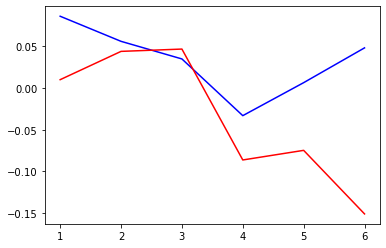

In [95]:
sr_pos = [1,2,3,4,5,6]
rn_nums = [1,2,3,4,5]
cntxt_types = ["SAFE", "THREAT"]
##for the group df that'll be made

all_safe1 = []
all_threat1 = []
all_safe2 = []
all_threat2 = []
all_safe3 = []
all_threat3 = []
all_safe4 = []
all_threat4 = []
all_safe5 = []
all_threat5 = []
all_safe6 = []
all_threat6 = []

rn = 5
sum_files = [f for f in listdir(final_outputs)]
for a in sum_files:
    pt = a[-6:-4]
    participants.append(pt)
    rd = pd.read_csv(final_outputs + a)
    
    safe1 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'SAFE') & (rd['cntxt_trialnum'] == 1)]
    threat1 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'THREAT') & (rd['cntxt_trialnum'] == 1)]

    safe2 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'SAFE') & (rd['cntxt_trialnum'] == 2)]
    threat2 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'THREAT') & (rd['cntxt_trialnum'] == 2)]

    safe3 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'SAFE') & (rd['cntxt_trialnum'] == 3)]
    threat3 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'THREAT') & (rd['cntxt_trialnum'] == 3)]

    safe4 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'SAFE') & (rd['cntxt_trialnum'] == 4)]
    threat4 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'THREAT') & (rd['cntxt_trialnum'] == 4)]

    safe5 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'SAFE') & (rd['cntxt_trialnum'] == 5)]
    threat5 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'THREAT') & (rd['cntxt_trialnum'] == 5)]
    
    safe6 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'SAFE') & (rd['cntxt_trialnum'] == 6)]
    threat6 = rd.loc[(rd['run_num'] == rn) & (rd['context_type'] == 'THREAT') & (rd['cntxt_trialnum'] == 6)]

    safe1_mn = np.mean(safe1.zcores)
    threat1_mn = np.mean(threat1.zcores)
    all_safe1.append(safe1_mn)
    all_threat1.append(threat1_mn)

    safe2_mn = np.mean(safe2.zcores)
    threat2_mn = np.mean(threat2.zcores)
    all_safe2.append(safe2_mn)
    all_threat2.append(threat2_mn)


    safe3_mn = np.mean(safe3.zcores)
    threat3_mn = np.mean(threat3.zcores)
    all_safe3.append(safe3_mn)
    all_threat3.append(threat3_mn)


    safe4_mn = np.mean(safe4.zcores)
    threat4_mn = np.mean(threat4.zcores)
    all_safe4.append(safe4_mn)
    all_threat4.append(threat4_mn)


    safe5_mn = np.mean(safe5.zcores)
    threat5_mn = np.mean(threat5.zcores)
    all_safe5.append(safe5_mn)
    all_threat5.append(threat5_mn)
    
    safe6_mn = np.mean(safe6.zcores)
    threat6_mn = np.mean(threat6.zcores)
    all_safe6.append(safe6_mn)
    all_threat6.append(threat6_mn)

    runs.append(rn)
    sr1.append(np.mean(all_safe1))
    sr2.append(np.mean(all_safe2))
    sr3.append(np.mean(all_safe3))
    sr4.append(np.mean(all_safe4))
    sr5.append(np.mean(all_safe5))
    sr6.append(np.mean(all_safe6))
    
    tr1.append(np.mean(all_threat1))
    tr2.append(np.mean(all_threat2))
    tr3.append(np.mean(all_threat3))
    tr4.append(np.mean(all_threat4))
    tr5.append(np.mean(all_threat5))
    tr6.append(np.mean(all_threat6))
    
    

#fig, axs = plt.subplots(len(rn_nums))  # 5 rows of plots
safes = [np.mean(all_safe1), np.mean(all_safe2), np.mean(all_safe3), np.mean(all_safe4), np.mean(all_safe5), np.mean(all_safe6)]
threats = [np.mean(all_threat1), np.mean(all_threat2), np.mean(all_threat3), np.mean(all_threat4), np.mean(all_threat5), np.mean(all_threat6)]
plt.plot(sr_pos, safes, label = "Safe", color = 'b')
plt.plot(sr_pos, threats, label = "Threat", color = 'r')

In [96]:
len(sr1)

180

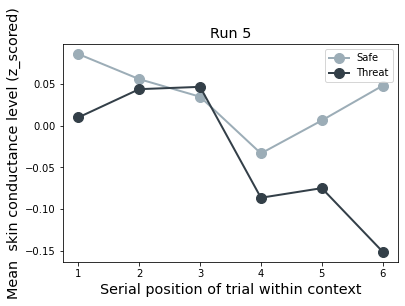

In [41]:
plt.plot(sr_pos, safes, color='#9cadb7', marker='o', linestyle='solid',
     linewidth=2, markersize=10, label = 'Safe')
plt.plot(sr_pos, threats, color='#333f48', marker='o', linestyle='solid',
     linewidth=2, markersize=10, label = 'Threat')

plt.xlabel("Serial position of trial within context", fontsize = "x-large")
plt.ylabel("Mean  skin conductance level (z_scored)", fontsize = "x-large")
plt.title("Run %s"%rn, fontsize = "x-large")
plt.legend()
plt.savefig('scl_run5.pdf')

In [97]:
#read the group csv
srpos_df = pd.DataFrame({"participant": participants,
                         "runs":runs,
                         "safe1":sr1,
                       "safe2":sr2,
                       "safe3":sr3,
                       "safe4":sr4,
                       "safe5":sr5,
                       "safe6":sr6,
                       "threat1":tr1,
                       "threat2":tr2,
                       "threat3":tr3,
                       "threat4":tr4,
                       "threat5":tr5,
                       "threat6":tr6})
srpos_df.to_csv('/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/srpos_trialnum.csv')

In [77]:
len(participants)

360

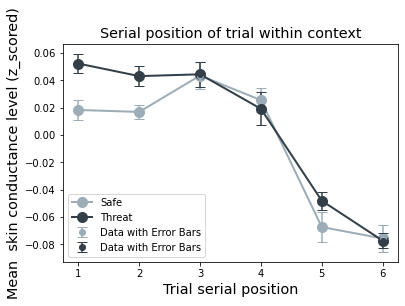

In [13]:
srpos_df = pd.read_csv('/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/srpos_trialnum.csv')
srpos = [1,2,3,4,5,6]
safes = [np.mean(srpos_df.safe1), np.mean(srpos_df.safe2), np.mean(srpos_df.safe3), np.mean(srpos_df.safe4), np.mean(srpos_df.safe5), np.mean(srpos_df.safe6)]
threats = [np.mean(srpos_df.threat1), np.mean(srpos_df.threat2), np.mean(srpos_df.threat3), np.mean(srpos_df.threat4), np.mean(srpos_df.threat5), np.mean(srpos_df.threat6)]
safe_sem= [stats.sem(srpos_df.safe1), stats.sem(srpos_df.safe2), stats.sem(srpos_df.safe3), stats.sem(srpos_df.safe4), stats.sem(srpos_df.safe5), stats.sem(srpos_df.safe6)]
threat_sem = [stats.sem(srpos_df.threat1), stats.sem(srpos_df.threat2), stats.sem(srpos_df.threat3), stats.sem(srpos_df.threat4), stats.sem(srpos_df.threat5), stats.sem(srpos_df.threat6)]

plt.plot(srpos, safes, color='#9cadb7', marker='o', linestyle='solid',
     linewidth=2, markersize=10, label = 'Safe')
plt.errorbar(srpos, safes, yerr=safe_sem, color = '#9cadb7', fmt='o', capsize=5, label='Data with Error Bars')

plt.plot(srpos, threats, color='#333f48', marker='o', linestyle='solid',
     linewidth=2, markersize=10, label = 'Threat')
plt.errorbar(srpos, threats, yerr=threat_sem, color = '#333f48', fmt='o', capsize=5, label='Data with Error Bars')

plt.xlabel("Trial serial position", fontsize = "x-large")
plt.ylabel("Mean  skin conductance level (z_scored)", fontsize = "x-large")
plt.title("Serial position of trial within context", fontsize = "x-large")
plt.legend()
plt.savefig('scl_bysrpos.pdf')

In [ ]:
## I could plot the scl by run
## I also need to do the by behavioral data check for final results section
## and then Lila's request :see how the scr is changing; then group again by type of context
## scl before and after shock

## SCL by run

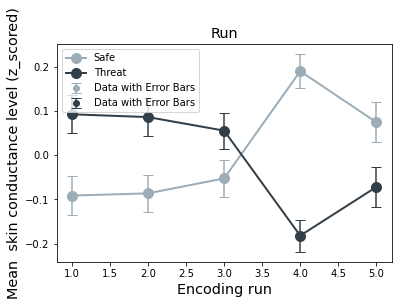

In [9]:
grp_df = pd.read_csv('/Users/ayesh/Desktop/Gradstuff/Temp_mem2022/SCL_final/grp_scr_newbatch4.csv')
rns = [1,2,3,4,5]
safes = [np.mean(grp_df.safe_run1), np.mean(grp_df.safe_run2), np.mean(grp_df.safe_run3), np.mean(grp_df.safe_run4), np.mean(grp_df.safe_run5)]
threats = [np.mean(grp_df.threat_run1), np.mean(grp_df.threat_run2), np.mean(grp_df.threat_run3), np.mean(grp_df.threat_run4), np.mean(grp_df.threat_run5)]
safe_sem = [stats.sem(grp_df.safe_run1), stats.sem(grp_df.safe_run2), stats.sem(grp_df.safe_run3), stats.sem(grp_df.safe_run4), stats.sem(grp_df.safe_run5)]
threat_sem = [stats.sem(grp_df.threat_run1), stats.sem(grp_df.threat_run2), stats.sem(grp_df.threat_run3), stats.sem(grp_df.threat_run4), stats.sem(grp_df.threat_run5)]

plt.plot(rns, safes, color='#9cadb7', marker='o', linestyle='solid',
     linewidth=2, markersize=10, label = 'Safe')
plt.errorbar(rns, safes, yerr=safe_sem, color = '#9cadb7', fmt='o', capsize=5, label='Data with Error Bars')

plt.plot(rns, threats, color='#333f48', marker='o', linestyle='solid',
     linewidth=2, markersize=10, label = 'Threat')
plt.errorbar(rns, threats, yerr=threat_sem, color = '#333f48', fmt='o', capsize=5, label='Data with Error Bars')

plt.xlabel("Encoding run", fontsize = "x-large")
plt.ylabel("Mean  skin conductance level (z_scored)", fontsize = "x-large")
plt.title("Run", fontsize = "x-large")
plt.legend()
plt.savefig('scl_byrun.pdf')

In [4]:
grp_df

,Unnamed: 0,participant,safe_run1,threat_run1,safe_run2,threat_run2,safe_run3,threat_run3,safe_run4,threat_run4,safe_run5,threat_run5
0,0,32,-0.419288,0.419288,-0.284329,0.284329,-0.212576,0.212576,-0.039191,0.048989,-0.328312,0.328312
1,1,34,-0.274295,0.274295,0.238326,-0.238326,-0.043843,0.043843,-0.000102,0.000102,0.071170,-0.071170
2,2,35,-0.378184,0.378184,-0.341551,0.341551,-0.022953,0.022953,0.479398,-0.479398,0.233697,-0.233697
3,3,36,-0.294517,0.294517,-0.196718,0.196718,-0.067636,0.067636,0.191555,-0.239444,0.369777,-0.369777
4,4,37,0.120247,-0.120247,0.036289,-0.036289,0.218232,-0.218232,0.032556,-0.026045,-0.045291,0.045291
5,5,38,0.271615,-0.271615,-0.482714,0.482714,-0.032997,0.032997,0.306136,-0.244909,0.442133,-0.442133
6,6,39,0.391480,-0.391480,-0.069378,0.069378,0.110830,-0.110830,-0.196826,0.157461,0.468522,-0.468522
7,7,41,0.115917,-0.115917,-0.207200,0.207200,0.389009,-0.389009,0.171139,-0.136911,-0.007524,0.007524
8,8,42,-0.498179,0.498179,0.351137,-0.438922,0.368723,-0.294979,0.469056,-0.586320,0.042473,-0.042473
9,9,43,-0.381131,0.381131,0.005477,-0.006846,0.031755,-0.025404,0.272453,-0.340566,0.393726,-0.393726
